In [9]:
import tskit as ts
import msprime as ms
import pyslim 
import demesdraw as dem
import numpy as np

## Recapitate Single Popualtions, to check if the recombination map works

In [10]:
orig_ts = ts.load('one_pop_recomb.trees')

In [11]:
max(t.num_roots for t in orig_ts.trees())

2

In [12]:
positions = []
rates = []
with open('recomb_map_ancestral.csv', 'r') as file:
  header = file.readline().strip().split(",")
  assert(header[0] == "ends" and header[1] == "rates")
  for line in file:
     components = line.split(",")
     positions.append(float(components[0]))
     rates.append(1e-8 * float(components[1]))

# step 1
positions.insert(0, 0)
# step 2
positions[-1] += 1
assert positions[-1] == orig_ts.sequence_length

recomb_map = ms.RateMap(position=positions, rate=rates)
recomb_map

left,right,mid,span,rate
0,21439,10719.5,21439,5.1e-17
21439,23439,22439,2000,2.5e-15
23439,73348,48393.5,49909,5.1e-17
73348,75348,74348,2000,2.5e-15
75348,117582,96465,42234,5.1e-17
117582,119582,118582,2000,2.5e-15
119582,128036,123809,8454,5.1e-17
128036,130036,129036,2000,2.5e-15
130036,371402,250719,241366,5.1e-17
371402,373402,372402,2000,2.5e-15


In [13]:
rts = pyslim.recapitate(orig_ts,
                recombination_rate=recomb_map,
                ancestral_Ne=1000)

max([t.num_roots for t in rts.trees()])

1

In [14]:
rng = np.random.default_rng(seed=3342)
alive_inds = pyslim.individuals_alive_at(rts, 0)
keep_indivs = rng.choice(alive_inds, 100, replace=False)
keep_nodes = []
for i in keep_indivs:
  keep_nodes.extend(rts.individual(i).nodes)

sts = rts.simplify(keep_nodes, keep_input_roots=True)

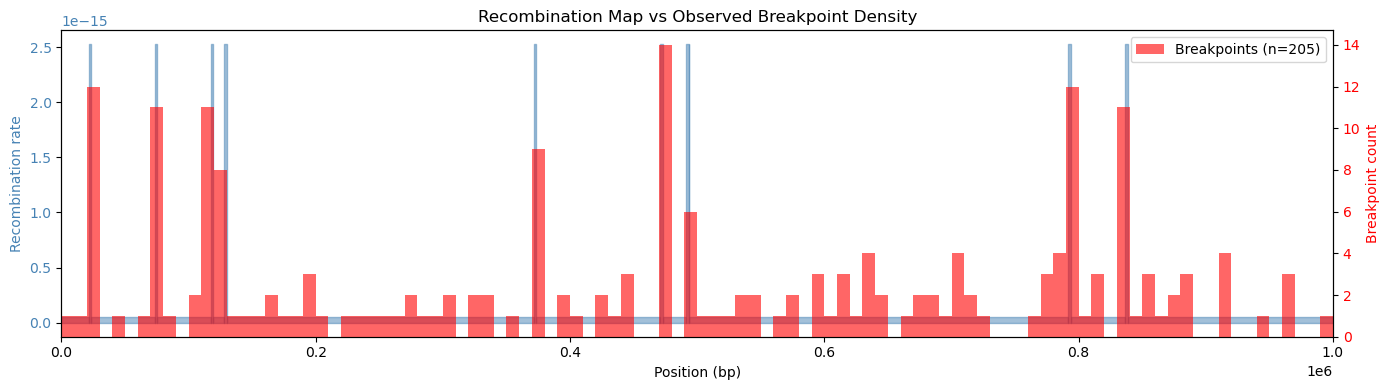

Total breakpoints: 205


In [16]:
import matplotlib.pyplot as plt

# Get breakpoints from the simplified tree sequence
breakpoints = np.array(list(sts.breakpoints()))
recomb_positions = breakpoints[1:-1]  # Exclude 0 and sequence_length

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# Plot recombination map as filled regions (hotspots)
map_positions = recomb_map.position
map_rates = recomb_map.rate

for i in range(len(map_rates)):
    left = map_positions[i]
    right = map_positions[i + 1]
    rate = map_rates[i]
    ax1.fill_between([left, right], 0, rate, alpha=0.5, color='steelblue', step='post')

# Histogram of breakpoints
n_bins = 100
counts, bin_edges = np.histogram(recomb_positions, bins=n_bins, range=(0, sts.sequence_length))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

ax2.bar(bin_centers, counts, width=bin_width, alpha=0.6, color='red', label=f'Breakpoints (n={len(recomb_positions)})')

ax1.set_xlabel('Position (bp)')
ax1.set_ylabel('Recombination rate', color='steelblue')
ax2.set_ylabel('Breakpoint count', color='red')
ax1.set_xlim(0, sts.sequence_length)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Recombination Map vs Observed Breakpoint Density')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"Total breakpoints: {len(recomb_positions)}")

## Recapitation and ancestry simulation with slim inbetween 